# **Stratification: Monte Carlo and Simulation**

In [19]:
!pip install ace_tools


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\trist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import numpy.random as rd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm # ajouté pour la q3
from scipy.stats.qmc import Sobol # ajouté pour la q3


## **Question 1**

We define the function $f$:

In [13]:
def f(u):
    return np.cos(2 * np.pi * (np.mean(u) - 1/2))

### **Monte-Carlo**

Notice that $I := \int_{[0, 1]^d} f(u) du = \mathbb{E}_{U \sim \mathcal{U}([0, 1]^d)}[f(U)]$. Thus, we can approximate $I$ using Monte Carlo.

In [18]:
def montecarlo(f, d, N = 10000):
    """
    Estimates the expected value of a function using the Monte Carlo method.

    Parameters:
    - d: The dimension of the random input vector.
    - N: The number of Monte Carlo simulations (default is 10,000).

    Returns:
    - The empirical mean of the function evaluations, approximating the expected value.
    """

    X = [f(rd.random(d)) for _ in range(N)]
    return np.mean(X)

Here are the results for different values of `N`:

In [19]:
d_values = [1, 2, 3, 5, 10, 100]
N_values = [100, 1000, 10000]

data = {N: [montecarlo(f, d, N) for d in d_values] for N in N_values}

df = pd.DataFrame(data, index = d_values)
df.iloc[:len(d_values)]

,100,1000,10000
1,-0.036613,-0.007514,-0.007076
2,0.422260,0.409897,0.398323
3,0.576623,0.545943,0.565937
5,0.720560,0.720014,0.712377
10,0.843448,0.847762,0.847043
100,0.984355,0.983388,0.983954


### **Quasi-Monte-Carlo**

For quasi-MC and for $d > 1$, like in the course slides, we need to generate $N$ points $u_1, \dots, u_N$ such that exactly one point falls in each strip of $\left\{\frac{1}{2N}, \frac{3}{2N}, \dots, \frac{2N - 1}{2N}\right\}^d$.

This is the goal of the function `generate_indices()`.

For the sake of clarity, instead of directly generating the points in $\left\{\frac{1}{2N}, \frac{3}{2N}, \dots, \frac{2N - 1}{2N}\right\}^d$, we will first generate them in $\{0, 1, \dots, N - 1\}^d$ and then apply the function $x \longmapsto \frac{2x + 1}{2N}$ to each coordinate of the output vector.

For $d = 2$, the above problem boils down to generating a permutation matrix $M = (m_{i, j}) \in \mathbb{R}^{N \times N}$, i.e. $m_{i, j} = \mathbf{1}_{i = \sigma(j)}$ for some permutation $\sigma$ of the set $\{0, 1, \dots, N - 1\}$.

For any $d \geq 2$, this boils down to generating a $d$-dimensional table $M = (m_{i_1, \dots, i_d}) \in \mathbb{R}^{N^d}$ such that$$m_{i_1, \dots, i_d} = \mathbf{1}_{i_1 = \sigma_2(i_2) = \cdots = \sigma_d(i_d)}$$where $\sigma_2, \dots, \sigma_d$ are $d - 1$ permutations of $\{0, 1, \dots, N - 1\}$.

The permutations are generated independently and uniformly on the (finite) set of permutations $\mathfrak{S}(\{0, 1, \dots, N - 1\})$.

In [20]:
def generate_indices(d, N = 10000):
    """
    Generates a vector of N points (u_1, ..., u_N) such that exactly one point falls in each strip of {1/(2N), 3/(2N), ..., (2N - 1)/(2N)}^d

    Parameters:
    - d: The dimension of the random input vector.
    - N: The number of Monte Carlo simulations (default is 10,000).

    Returns:
    - A numpy array of size (N, d), representing the desired vector.
    """

    list_indices = []
    X = []  #inutile ici ? 
    arr = np.array(list(range(N)))

    # Generate perm such that perm[k] is the matrix M = (m_{i, j}) of the permutation \sigma_{k + 2}^{-1}
    perm = [rd.permutation(arr) for _ in range(d - 1)]

    for i in range(N):
        # For all k = 1, ... N - 1, get the value of \sigma_{k + 2}^{-1}(i), i.e. the indice j such that m_{i, j} = 1
        indices = [i] + [perm[k][i] for k in range(d - 1)]
        list_indices.append(indices)

    list_indices = np.array(list_indices)
    list_indices = (2 * list_indices + 1)/(2 * N)
    return list_indices

Let's visualize what this function does.

Case $d = 2$: this is what `generate_indices(2, 10)` corresponds to:

[[0.05 0.65]
 [0.15 0.75]
 [0.25 0.15]
 [0.35 0.05]
 [0.45 0.25]
 [0.55 0.95]
 [0.65 0.45]
 [0.75 0.55]
 [0.85 0.35]
 [0.95 0.85]]


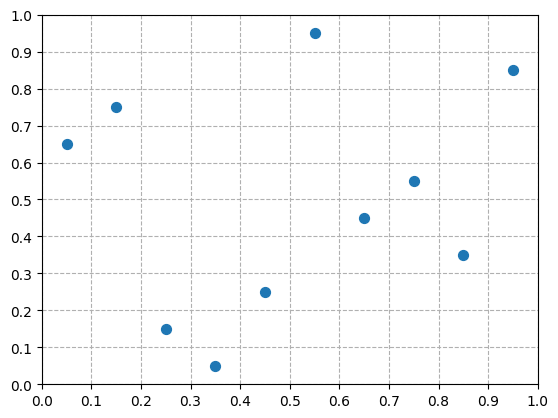

In [21]:
points = generate_indices(2, 10)

print(points)

x = points[:, 0]
y = points[:, 1]

plt.scatter(x, y, s = 50)
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, 1, 11))
plt.grid(True, linestyle = '--')
plt.show()

Case $d = 3$: this is what `generate_indices(3, 10)` corresponds to:

[[0.05 0.45 0.65]
 [0.15 0.65 0.15]
 [0.25 0.55 0.35]
 [0.35 0.35 0.95]
 [0.45 0.75 0.55]
 [0.55 0.95 0.45]
 [0.65 0.25 0.05]
 [0.75 0.85 0.85]
 [0.85 0.05 0.75]
 [0.95 0.15 0.25]]


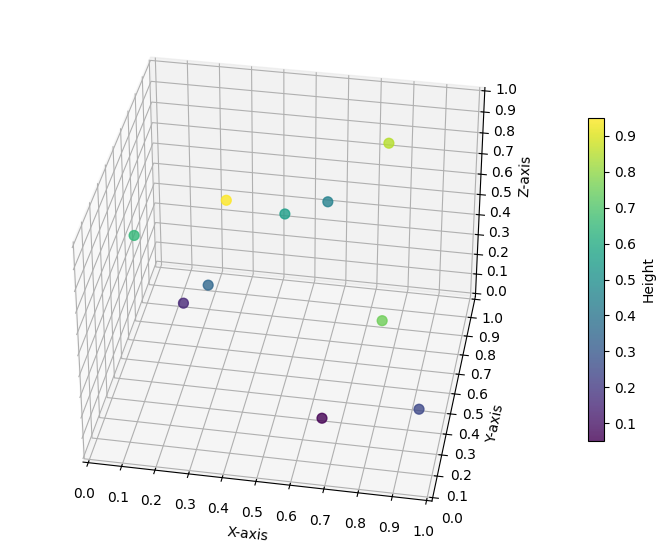

In [22]:
points = generate_indices(3, 10)

print(points)

x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

fig = plt.figure(figsize = (10, 7))
ax = fig.add_subplot(111, projection = '3d')

# Grid
ax.set_xticks(np.linspace(0, 1, 11))
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_zticks(np.linspace(0, 1, 11))
ax.grid(True, linestyle = '--')

# Point of view
ax.view_init(elev = 35, azim = -80)

# The color is a function of height
sc = ax.scatter(x, y, z,
                c = z,
                cmap = 'viridis',
                s = 50,
                alpha = 0.8)
cbar = plt.colorbar(sc, ax = ax, shrink = 0.6)
cbar.set_label("Height")

# Label of each axes
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")

plt.show()

An interactive version of the above graph can be plotted using `plotly`:

In [23]:
import plotly.graph_objects as go

# Générer les points
points = generate_indices(3, 10)
x = points[:, 0]
y = points[:, 1]
z = points[:, 2]

# Création du scatter plot 3D interactif avec Plotly
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=x, y=y, z=z,
    mode='markers',
    marker=dict(
        size=5,
        color=z,  # Couleur en fonction de la hauteur
        colorscale='viridis',
        opacity=0.8
    )
))

# Mise en forme des axes et du fond
fig.update_layout(
    title="Graphique 3D Interactif",
    scene=dict(
        xaxis=dict(title="X-axis", showgrid=True, gridcolor="lightgray"),
        yaxis=dict(title="Y-axis", showgrid=True, gridcolor="lightgray"),
        zaxis=dict(title="Z-axis", showgrid=True, gridcolor="lightgray"),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

# Affichage interactif
fig.show()

Henceforth, we may use the function `generate_indices()` to generate a vector $(u_1, \dots, u_N)$ as described above, and return the mean of $X = (f(u_1), \dots, f(u_N))$.
- For $d = 1$, the function is not needed, we simply use $(u_1, \dots, u_N) = \left(\frac{1}{2N}, \frac{3}{2N}, \dots, \frac{2N - 1}{2N}\right)$ ;
- For $d > 1$, the vector $(u_1, \dots, u_N)$ is given by the output of `generate_indices(d, N)`.

In [24]:
def quasimontecarlo(f, d, N = 10000):
    if d == 1:
        X = [f((2 * n + 1)/(2 * N)) for n in range(N)]
    if d > 1:
        list_indices = generate_indices(d, N)
        X = [f(u) for u in list_indices]
    return np.mean(X)

For $d = 1$, we have $I = \int_0^1 \cos\left(2 \pi \left(u - \frac{1}{2}\right)\right) du = \frac{1}{2\pi} \int_{-\pi}^\pi \cos(t) dt = 0$. We can see below that quasi-MC is much better than MC.

In [25]:
float(montecarlo(f, 1)), float(quasimontecarlo(f, 1))

(-0.009649027463008358, 4.5474735088646414e-17)

For $d > 1$: bon ça marche mais c'est trop bizarre car c'est à peu du même ordre que MC...

In [26]:
m1 = np.mean([montecarlo(f, 2) for _ in range(10)])
m2 = np.mean([quasimontecarlo(f, 2) for _ in range(10)])
v1 = np.var([montecarlo(f, 2) for _ in range(10)])
v2 = np.var([quasimontecarlo(f, 2) for _ in range(10)])
float(m1), float(m2), float(v1), float(v2)

(0.40377262684673754,
 0.40372405909437237,
 2.6231878650209228e-05,
 1.1090541320750768e-05)

## **Question 2**

Let
$$\mathfrak{C}_k := \left\{\left(\frac{2j_1 + 1}{2k}, \dots, \frac{2j_d + 1}{2k}\right) \quad \text{s.t.} \quad (j_1, \dots, j_d) \in \{0, 1, \dots, k - 1\}^d\right\}$$

Haber's first estimator is defined by
$$\hat{I}_{1,k}(f) := \frac{1}{k^d} \sum_{c \in \mathfrak{C}_k} f(c + U_c), \quad U_c \sim \mathcal{U}\left(\left[-\frac{1}{2k}, \frac{1}{2k}\right]^d\right)$$

In [12]:
# Define the set of the centres of the k^d hypercubes
import itertools
def c_0k(d, k):
    return np.array([[(2*j + 1) / (2*k) for j in point] for point in itertools.product(range(k), repeat=d)])


In [13]:
c_0k(2, 5)

array([[0.1, 0.1],
       [0.1, 0.3],
       [0.1, 0.5],
       [0.1, 0.7],
       [0.1, 0.9],
       [0.3, 0.1],
       [0.3, 0.3],
       [0.3, 0.5],
       [0.3, 0.7],
       [0.3, 0.9],
       [0.5, 0.1],
       [0.5, 0.3],
       [0.5, 0.5],
       [0.5, 0.7],
       [0.5, 0.9],
       [0.7, 0.1],
       [0.7, 0.3],
       [0.7, 0.5],
       [0.7, 0.7],
       [0.7, 0.9],
       [0.9, 0.1],
       [0.9, 0.3],
       [0.9, 0.5],
       [0.9, 0.7],
       [0.9, 0.9]])

In [14]:
def haber_estimator_1(d, k, N = 10000):
    c_0k_point = c_0k(d, k)
    U_c = np.random.uniform(-1/(2*k), 1/(2*k), size = (N, d))
    X = [f(u + c) for c,u in zip(c_0k_point, U_c)]
    return np.sum(X)/(k**d)

In [15]:
m = np.mean([haber_estimator_1(2,5) for _ in range(10)])
v = np.var([haber_estimator_1(2,5) for _ in range(10)])
float(m), float(v)

(0.4083525115318499, 0.0003890845324669067)

Let
$$g_c(u) := \frac{f(c + u) + f(c - u)}{2}$$

Haber's second estimator is the following:
$$\hat{I}_{2,k}(f) := \frac{1}{k^d} \sum_{c \in \mathfrak{C}_k} g_c(U_c), \quad U_c \sim \mathcal{U}\left(\left[-\frac{1}{2k}, \frac{1}{2k}\right]^d\right)$$


In [16]:
def haber_estimator_2(d, k, N = 10000):
    c_0k_point = c_0k(d, k)
    U_c = np.random.uniform(-1/(2*k), 1/(2*k), size = (N, d))
    X = [(f(c + u) + f(c - u))/2 for c,u in zip(c_0k_point, U_c)]
    return np.sum(X)/(k**d)

In [17]:
float(haber_estimator_1(2,5)), float(haber_estimator_2(2,5))

(0.33055076926404064, 0.4099916560979095)

In [18]:
m = np.mean([haber_estimator_2(2,5) for _ in range(10)])
v = np.var([haber_estimator_2(2,5) for _ in range(10)])
float(m), float(v)

(0.40624639257325834, 2.7883007320582946e-05)

## **Question 3**
### **Approximation of the integral using importance sampling**


#### The central limit theorem enables us to make the following approximation :



Each $u_i \sim \mathcal{U}([0,1])$ has expectation $\mathbb{E}[u_i] = \frac{1}{2}$, and variance $\operatorname{Var}(u_i) = \frac{1}{12}$

Thereforce, by the TCL :

$$\sqrt{d}\left(M_d - \frac{1}{2}\right) \xrightarrow{d \to \infty} \mathcal{N}\left(0, \frac{1}{12}\right) \quad \Rightarrow \quad M_d \approx \mathcal{N}\left(\frac{1}{2}, \frac{1}{12d}\right)$$



When $d$ is large enough :

$\frac{1}{d} \sum_{i=1}^{d} u_i \sim \mathcal{N}\left(\frac{1}{2}, \frac{1}{12d}\right)$


This allows us to construct an importance sampling strategy to efficiently evaluate this integral.

We will generate samples $u \in [0, 1]^d$ where the mean approximately follows a normal distribution centered at $0.5$, with variance $\frac{1}{12d}$.

Then, we adjust the weights with the normal density to correct for bias, as in the importance sampling formula:

$$
I \approx \frac{1}{N} \sum_{i=1}^N \frac{f(u^{(i)})}{p(u^{(i)})}
$$


In [27]:
def importance_sampling(f, d, N, plot=False):
    # Parameters of the normal distribution for the mean
    mu = 0.5
    sigma = np.sqrt(1 / (12 * d))

    # Drawing means according to the normal distribution
    mean_samples = norm.rvs(loc=mu, scale=sigma, size=N)
    mean_samples = np.clip(mean_samples, 0, 1)

    # Generating points in [0,1]^d
    samples = np.random.rand(N, d)
    sample_means = np.mean(samples, axis=1, keepdims=True)
    
    # Adjustment to make the mean of each vector as desired
    samples = samples - sample_means + mean_samples[:, np.newaxis]
    samples = np.clip(samples, 0, 1)

    # Function evaluation and weights
    values = f(samples)
    weights = norm.pdf(np.mean(samples, axis=1), loc=mu, scale=sigma)

    # Estimation
    estimate = np.mean(values / weights)

    # Visualization
    if plot:
        plt.hist(np.mean(samples, axis=1), bins=30, alpha=0.6, label="Sample Means", density=True)
        x = np.linspace(0, 1, 500)
        plt.plot(x, norm.pdf(x, loc=mu, scale=sigma), label="Normal PDF", color="red")
        plt.title(f"Distribution of Means (d={d})")
        plt.legend()
        plt.grid(True)
        plt.show()

    return np.mean(estimate)

In [29]:
importance_sampling(f, 10, 1000)

0.4636546157848966

Code de Camille

In [162]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def importance_sampling(f, d, N, plot=False):
    # Paramètres de la loi normale
    mu = 0.5
    sigma = np.sqrt(1 / (12 * d))

    # Tirage de moyennes selon N(mu, sigma^2), tronquée à [0,1]
    mean_samples = norm.rvs(loc=mu, scale=sigma, size=N)
    mean_samples = np.clip(mean_samples, 0, 1)

    # Génération de vecteurs aléatoires uniformes dans [0,1]^d
    samples = np.random.rand(N, d)
    sample_means = np.mean(samples, axis=1, keepdims=True)

    # Ajustement des vecteurs pour qu'ils aient la moyenne souhaitée
    samples = samples - sample_means + mean_samples[:, np.newaxis]
    samples = np.clip(samples, 0, 1)

    # Évaluation de la fonction f
    values = f(samples)

    # Calcul des poids (densité de la moyenne sous loi normale, normalisée)
    sample_mean = np.mean(samples, axis=1)
    Z = norm.cdf(1, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)  # normalisation sur [0,1]
    weights = norm.pdf(sample_mean, loc=mu, scale=sigma) / Z

    # Estimateur importance sampling
    estimate = values / weights

    # Option : affichage de la distribution des moyennes
    if plot:
        plt.hist(sample_mean, bins=30, alpha=0.6, label="Sample Means", density=True)
        x = np.linspace(0, 1, 500)
        plt.plot(x, norm.pdf(x, loc=mu, scale=sigma) / Z, label="Normalized PDF", color="red")
        plt.title(f"Distribution of Sample Means (d={d})")
        plt.legend()
        plt.grid(True)
        plt.show()

    return np.mean(estimate)


Code de Tristan 

In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

def importance_sampling(f, d, N, plot=False):
    # Paramètres de la loi de proposal (normale centrée en 0.5, variance 1/(12d))
    mu = 0.5
    sigma = np.sqrt(1 / (12 * d))
    
    # Génération de N échantillons iid suivant g = N(mu, sigma^2)
    samples = np.random.normal(loc=mu, scale=sigma, size=(N, d))
    
    # Calcul des poids importance : f(x) / g(x)
    # Ici, f est la densité uniforme sur [0,1]^d, donc f(x) = 1 si x ∈ [0,1]^d, sinon 0
    # g(x) est la densité multivariée normale (indépendante par dimension)
    in_support = np.all((samples >= 0) & (samples <= 1), axis=1)
    uniform_density = 1.0  # densité de f sur [0,1]^d
    g_density = np.prod(norm.pdf(samples, loc=mu, scale=sigma), axis=1)
    
    values = np.zeros(N)
    weights = np.zeros(N)

    # On applique f seulement sur les points dans le support
    valid_samples = samples[in_support]
    values[in_support] = f(valid_samples)
    weights[in_support] = uniform_density / g_density[in_support]

    estimate = values * weights
    result = np.mean(estimate)

    if plot:
        sample_means = np.mean(samples, axis=1)
        Z = norm.cdf(1, loc=mu, scale=sigma) - norm.cdf(0, loc=mu, scale=sigma)
        plt.hist(sample_means, bins=30, density=True, alpha=0.6, label="Sample Means")
        x = np.linspace(0, 1, 500)
        plt.plot(x, norm.pdf(x, loc=mu, scale=sigma) / Z, label="Normalized PDF", color="red")
        plt.title(f"Importance Sampling Sample Means (d={d})")
        plt.grid(True)
        plt.legend()
        plt.show()

    return result


### **Testing the algorithm for multiple dimensions**

We test importance sampling for different values of $d$, and visualize the distribution for $d = 10$.

d =  2 → Estimation ≈ 0.405421
d =  5 → Estimation ≈ 0.403797
d = 10 → Estimation ≈ 0.009775
d = 20 → Estimation ≈ 0.000000
d = 50 → Estimation ≈ 0.000000


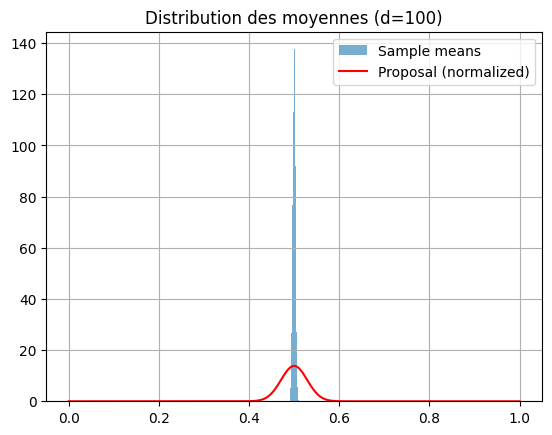

d = 100 → Estimation ≈ 0.000000


In [ ]:
for d in [2, 5, 10, 20, 50, 100]:
    I = importance_sampling(f, d, N=10000, plot=(d == 100))
    print(f"d = {d:>2} → Estimation ≈ {I:.6f}")

On peut comparer la convergence entre la moyenne d'un vecteur dont les coordonnées suivent une loi uniforme dans [0;1]^d avec une variable aléatoire réelle de loi normale (1/2;1/12d)

In [ ]:
# Réimporter les bibliothèques après reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Moyenne de d lois uniformes sur [0, 1]
def moyenne_uniformes(d, N):
    u = np.random.rand(N, d)
    return np.mean(u, axis=1)

# Tirage de N valeurs selon une loi normale N(0.5, 1/(12d))
def tirage_normale(d, N):
    mu = 0.5
    sigma = np.sqrt(1 / (12 * d))
    return norm.rvs(loc=mu, scale=sigma, size=N)

# Plages de dimensions à tester
dimensions = [10*i for i in range(100)]
N = 10000

# Moyennes pour chaque méthode
mean_uniformes = []
mean_normales = []

for d in dimensions:
    mean_u = np.mean(moyenne_uniformes(d, N))
    mean_n = np.mean(tirage_normale(d, N))
    mean_uniformes.append(mean_u)
    mean_normales.append(mean_n)

# Tracé
plt.figure(figsize=(10, 6))
plt.plot(dimensions, mean_uniformes, marker='o', label='Moyenne de lois uniformes')
plt.plot(dimensions, mean_normales, marker='s', label='Tirage loi normale N(0.5, 1/(12d))')
plt.axhline(0.5, color='gray', linestyle='--', label='Valeur cible : 0.5')
plt.xlabel("Dimension d")
plt.ylabel("Moyenne empirique")
plt.title("Convergence vers 1/2 selon la méthode")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.tight_layout()
plt.show()

In [38]:
def tirage_normale(d, N):
    mu = 0.5
    sigma = np.sqrt(1 / (12 * d))
    return norm.rvs(loc=mu, scale=sigma, size=N)

def f_scalar(x):
    return np.cos(2 * np.pi * (x - 0.5))

def MonteCarloNormal(f_scalar, d, N):
    return np.mean(f_scalar(tirage_normale(d, N)))

On va maiçntenant comparer les résultats obtenus avec la méthode Monte Carlo, et Quasi Monte Carlo

In [39]:
d = 1000
N = 100000

mc = montecarlo(f, d, N)
qmc = quasimontecarlo(f, d, N)
is_estimate = importance_sampling(f, d, N)
mc_norm = MonteCarloNormal(f_scalar, d, N)

print(f"Monte Carlo (naïf)        : {mc}")
print(f"Monte Carlo (normale)       : {mc_norm}")
print(f"Quasi Monte Carlo (Sobol)        : {qmc}")
print(f"Importance Sampling       : {is_estimate}")

Monte Carlo (naïf)        : 0.9983495717748089
Monte Carlo (normale)       : 0.9983574096105272
Quasi Monte Carlo (Sobol)        : 0.9983501097817662
Importance Sampling       : 0.06754691947076938


On va rgarder la convergence sur un graphique :

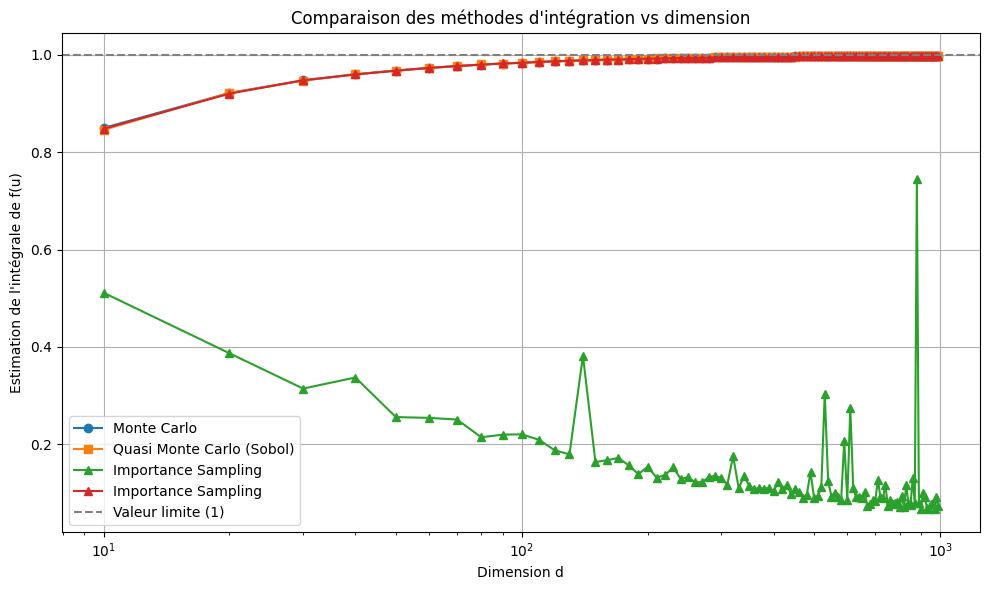

In [52]:
# Réduction du nombre d'échantillons pour éviter l'explosion mémoire avec Sobol
N = 16384  # 2^14, bien adapté pour Sobol
dimensions = [10*i for i in range(1, 100)]

# Réinitialiser les listes de résultats
mc_results = []
qmc_results = []
mc_normal_results = []
is_results = []

for d in dimensions:
    mc_results.append(montecarlo(f, d, N))
    qmc_results.append(quasimontecarlo(f, d, N))
    is_results.append(importance_sampling(f, d, N))
    mc_normal_results.append(MonteCarloNormal(f_scalar, d, N))

# Tracé des résultats mis à jour
plt.figure(figsize=(10, 6))
plt.plot(dimensions, mc_results, marker='o', label='Monte Carlo')
plt.plot(dimensions, qmc_results, marker='s', label='Quasi Monte Carlo (Sobol)')
plt.plot(dimensions, is_results, marker='^', label='Importance Sampling')
plt.plot(dimensions, mc_normal_results, marker='^', label='Importance Sampling')
plt.axhline(1, color='gray', linestyle='--', label='Valeur limite (1)')
plt.xlabel("Dimension d")
plt.ylabel("Estimation de l'intégrale de f(u)")
plt.title("Comparaison des méthodes d'intégration vs dimension")
plt.legend()
plt.grid(True)
plt.xscale("log")
plt.tight_layout()
plt.show()
